In [21]:
import mmcv

mmcv.collect_env()

from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector
from mmrotate.models import build_detector

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import rotate

import grpc
import messaging_pb2
import messaging_pb2_grpc

import os
import sys
import random
import cv2
import time


class ImageProcessingLayer:
    def __init__(
        self,
        mock=True,
        mock_image_path=None,
        mock_num_samples=10,
        mock_wait_time=1,
    ):
        self.mock = mock

        if not mock:
            return

        self.mock_wait_time = mock_wait_time

        if mock_image_path is None:
            mock_image_path = "data/demo.jpg"

        self._mock_img_full = np.asarray(Image.open(mock_image_path))
        self._output_dim = (200, 200)
        diag_len = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)
        self._gcps_pixels = self._generate_random_gcps(
            self._mock_img_full, mock_num_samples, padding=(diag_len, diag_len)
        )

        # maybe convert from pixels to lat/lon here

        self._path_pixels = self._build_path_pixels(self._gcps_pixels)

    def _generate_random_gcps(self, img, num_samples, padding=(0, 0)):
        return np.random.randint(
            padding,
            high=(img.shape[0] - padding[0], img.shape[1] - padding[1]),
            size=(num_samples, 2),
        )

    def _build_path_pixels(self, gcps):
        delta = np.diff(gcps, axis=0)
        directions = delta / np.linalg.norm(delta, axis=1).reshape(-1, 1)
        angles = np.arctan2(directions.T[1], directions.T[0]) * 180 / np.pi
        delta_angles = np.append(np.diff(angles), 0)

        path = []

        for t1, t2, angle, delta_angle in zip(gcps, gcps[1:], angles, delta_angles):
            steps = np.linalg.norm(t2 - t1) / 90
            line = np.linspace(t1, t2, steps.astype("uint32"), dtype="uint32")
            path.extend([np.array([x, y, angle]) for x, y in line])

            if delta_angle == 0:
                continue

            if len(line) == 0:
                continue

            interpolated_angles = np.linspace(angle, angle + delta_angle, 3)
            path.extend(
                [
                    np.array([line[-1][0], line[-1][1], theta])
                    for theta in interpolated_angles
                ]
            )

        return path

    def _next_image(self):
        if self.mock_wait_time > 0:
            time.sleep(self.mock_wait_time)

        sample_diag = np.sqrt(self._output_dim[0] ** 2 + self._output_dim[1] ** 2)

        for x, y, theta in self._path_pixels:
            sample = self._crop_around(
                self._mock_img_full, (y, x), (sample_diag, sample_diag)
            )
            rotated_img = self._center_crop(
                rotate(sample, -theta, reshape=False), self._output_dim
            )
            yield rotated_img

    def _crop_around(self, img, center, dim):
        dim = np.array(dim).astype("uint32")
        x = int(center[1] - dim[1] // 2)
        y = int(center[0] - dim[0] // 2)
        return img[y : y + dim[0], x : x + dim[1]]

    def _center_crop(self, img, dim):
        return img[
            img.shape[0] // 2 - dim[0] // 2 : img.shape[0] // 2 + dim[0] // 2,
            img.shape[1] // 2 - dim[1] // 2 : img.shape[1] // 2 + dim[1] // 2,
        ]

    def run(self, img=None):
        if not self.mock:
            assert img is not None, "Image cannot be None"
            return img

        return self._next_image()


class ObjectDetectionLayer:
    def __init__(
        self, config_file=None, checkpoint_file=None, device="cuda", min_confidence=0.3
    ):
        if config_file is None:
            config_file = "examples/oriented_rcnn_r50_fpn_1x_dota_le90.py"
        if checkpoint_file is None:
            checkpoint_file = "examples/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth"

        self.config_file = config_file
        self.checkpoint_file = checkpoint_file
        self.device = device

        self.model = self._load_model()
        self.min_confidence = min_confidence

    def _load_model(self):
        config = mmcv.Config.fromfile(self.config_file)
        config.model.pretrained = None

        model = build_detector(config.model)
        checkpoint = load_checkpoint(
            model, self.checkpoint_file, map_location=self.device
        )

        model.CLASSES = checkpoint["meta"]["CLASSES"]
        model.cfg = config
        model.to(self.device)
        model = model.eval()

        return model

    def _get_bboxes_pixels(self, img):
        vehicle_classes = [
            i for i, c in enumerate(self.model.CLASSES) if "vehicle" in c
        ]

        inference = inference_detector(self.model, img)
        bboxes = [inference[index] for index in vehicle_classes]

        bboxes = np.concatenate(bboxes, axis=0)
        bboxes = bboxes[bboxes[:, 5] > self.min_confidence]

        # the bboxes are in a weird polygonal format, so we convert them to rectangles
        rect_bboxes = (
            np.array(
                [
                    bboxes[:, 1] - bboxes[:, 2] // 2,
                    bboxes[:, 1] + bboxes[:, 2] // 2,
                    bboxes[:, 0] - bboxes[:, 2] // 2,
                    bboxes[:, 0] + bboxes[:, 3],
                    100 * bboxes[:, -1],  # confidence score
                ]
            )
            .astype(int)
            .T
        )

        # follows the format of x0, x1, y0, y1, confidence
        return rect_bboxes

    def run(self, img):
        result = self._get_bboxes_pixels(img)

        # convert pixels to lat/lon here
        return result


class MavlinkInterfaceLayer:
    def __init__(self, protos_path="pipelined_grpc/protos"):
        self.protos_path = protos_path
        self.channel = grpc.insecure_channel("localhost:50051")
        pass

    def run(self, bboxes):
        if len(bboxes) == 0:
            return

        print(bboxes)

load checkpoint from local path: examples/oriented_rcnn_r50_fpn_1x_dota_le90-6d2b2ce0.pth
[[ 81  95 169 181  75]
 [ 80  94 175 188  72]
 [ 79  93 181 192  46]]


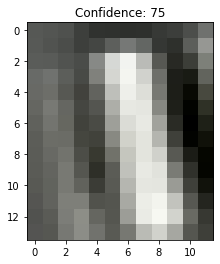

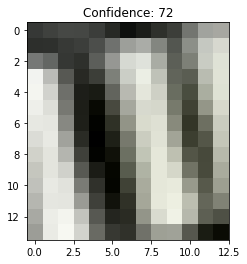

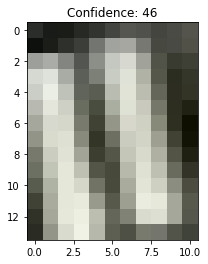

[[ 81  95 169 181  75]
 [ 80  94 175 188  72]
 [ 79  93 181 192  46]]


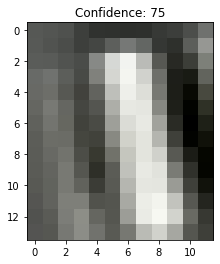

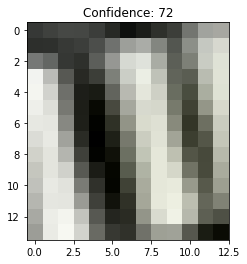

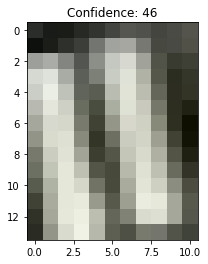

[[ 15  29 125 138  63]
 [ 10  24 127 139  60]
 [ 22  36 123 136  56]
 [  4  18 129 141  53]
 [  0  13 131 143  48]]


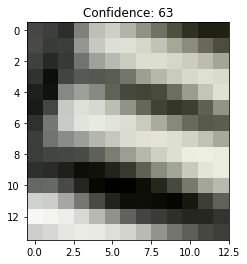

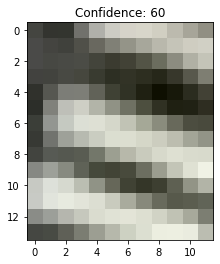

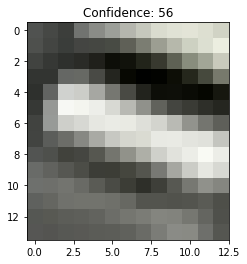

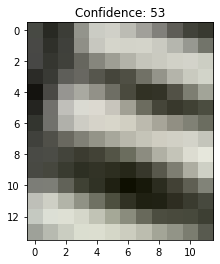

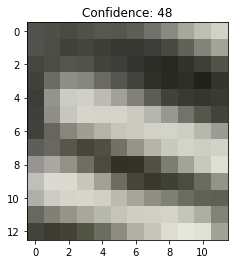

[[29 43 48 61 64]
 [24 38 44 57 39]]


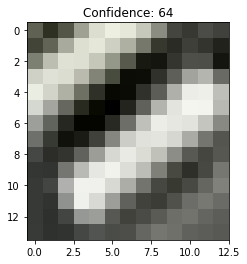

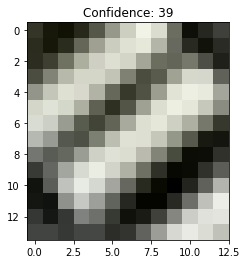

[[ 83  97 131 144  37]
 [ 40  54  97 109  32]
 [ 79  91 128 140  31]]


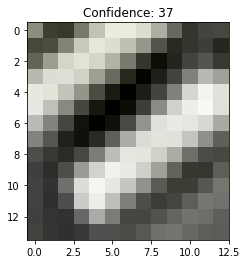

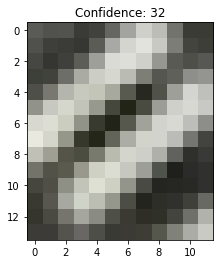

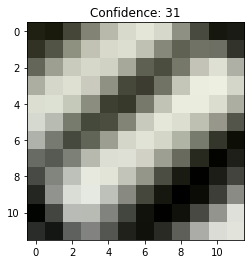

[[ 96 110  10  22  44]
 [ 93 107   6  18  30]]


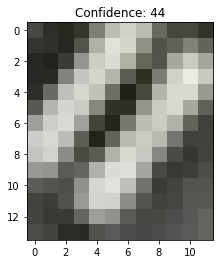

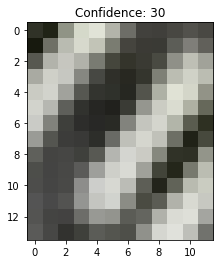

[[ 96 110  10  22  44]
 [ 93 107   6  18  30]]


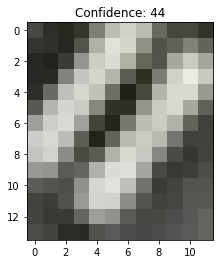

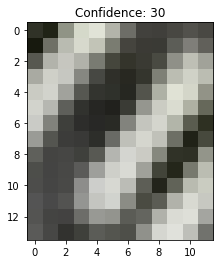

[[ 61  75 173 184  33]]


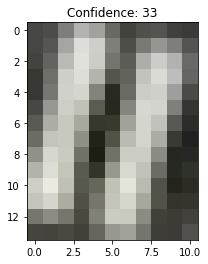

[[151 165  29  40  75]
 [150 164  34  45  66]
 [151 165  22  34  55]
 [152 166  10  22  48]
 [152 166  17  29  32]]


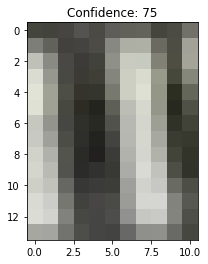

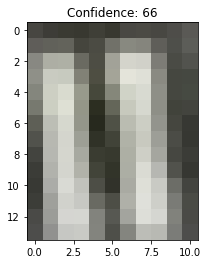

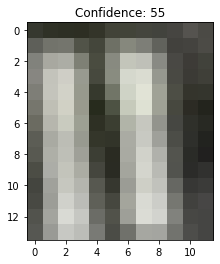

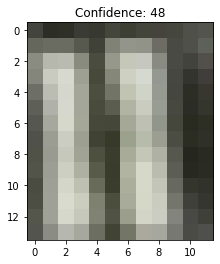

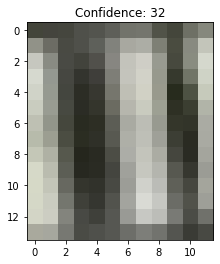

In [25]:
img_layer = ImageProcessingLayer(mock_wait_time=1)
obj_layer = ObjectDetectionLayer()
mav_layer = MavlinkInterfaceLayer()

for img in img_layer.run():
    bboxes = obj_layer.run(img)
    mav_layer.run(bboxes)

    # for bbox in bboxes:
    #     plt.imshow(img[bbox[0]:bbox[1], bbox[2]:bbox[3]])
    #     plt.title("Confidence: {}".format(bbox[4]))
    #     plt.show()